In [25]:
import xarray as xr

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar
import seaborn as sns

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod

In [55]:
def make_fn(case, v_x, v_y, comment=''):
    _x = v_x.split('(')[0]
    _y = v_y.split('(')[0]
    f = f'cloud_props_ATTO_{comment}_{case}_{_x}_{_y}.png'
    return plot_path /f



In [56]:
plot_path = Path('Plots')
plot_path.mkdir(parents=True, exist_ok=True) 

In [57]:
xr.set_options(keep_attrs=True) 

## Get observational data

In [58]:
import pandas as pd

In [59]:
from bs_fdbck.constants import path_measurement_data

In [60]:
fn = path_measurement_data / 'SourceData_Yli_Juuti2021.xls'

df_hyy_1 = pd.read_excel(fn, sheet_name=4, header=1,)# usecols=range(7,12),nrows=7)

df_hyy_1.head()
#df_hyy_1y= df_hyy_1y.rename({'year.1':'year',
#                            'T (degree C).1':'T (degree C)',
#                             'OA (microgram m^-3).1':'OA (microgram m^-3)',
#                             'N100 (cm^-3).1':'N100 (cm^-3)'
#                            }, axis=1)
#df_hyy_1y['year'] = pd.to_datetime(df_hyy_1y['year'].apply(x:str(x)))

df_hyy_1

,year,month,day,LAT,LON,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
0,2012,7,5,60.5,22.5,3.218589,191,12.940000,26.219999
1,2012,7,10,60.5,22.5,4.714353,172,10.950000,24.430000
2,2012,7,14,60.5,22.5,1.451827,106,15.790000,12.030000
3,2012,7,19,60.5,22.5,3.101941,262,16.039999,28.650000
4,2012,7,22,60.5,22.5,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
3668,2018,8,13,65.5,29.5,0.674785,191,15.200000,18.969999
3669,2018,8,14,65.5,29.5,1.356364,291,15.200000,31.449999
3670,2018,8,19,65.5,29.5,0.916047,139,18.230000,11.960000
3671,2018,8,20,65.5,29.5,1.325436,177,14.049999,19.869999


In [61]:
import pandas as pd

In [62]:
df_hyy_1['date'] = df_hyy_1.apply(lambda x: f'{x.year:.0f}-{x.month:02.0f}-{x.day:02.0f}', axis=1)

df_hyy_1['date'] = pd.to_datetime(df_hyy_1['date'] )

In [63]:
df_hyy_1 = df_hyy_1.set_index(['date','LAT','LON'])

In [64]:
df_hyy_1

,,,year,month,day,OA (microgram m^-3),CWP (g m^-2),CER (micrometer),COT
date,LAT,LON,,,,,,,
2012-07-05,60.5,22.5,2012,7,5,3.218589,191,12.940000,26.219999
2012-07-10,60.5,22.5,2012,7,10,4.714353,172,10.950000,24.430000
2012-07-14,60.5,22.5,2012,7,14,1.451827,106,15.790000,12.030000
2012-07-19,60.5,22.5,2012,7,19,3.101941,262,16.039999,28.650000
2012-07-22,60.5,22.5,2012,7,22,0.875789,92,10.630000,14.820000
...,...,...,...,...,...,...,...,...,...
2018-08-13,65.5,29.5,2018,8,13,0.674785,191,15.200000,18.969999
2018-08-14,65.5,29.5,2018,8,14,1.356364,291,15.200000,31.449999
2018-08-19,65.5,29.5,2018,8,19,0.916047,139,18.230000,11.960000


In [65]:
#df_hyy_1['OA_category']

df_hyy_1['OA_low'] = df_hyy_1['OA (microgram m^-3)']<2
df_hyy_1['OA_high']= df_hyy_1['OA (microgram m^-3)']>2
ddf_hyy_1=df_hyy_1.assign(OA_category= pd.NA)
df_hyy_1.loc[df_hyy_1['OA_high'], 'OA_category'] = 'OA high'
df_hyy_1.loc[df_hyy_1['OA_low'], 'OA_category'] = 'OA low'



In [66]:
bins = pd.IntervalIndex.from_tuples([(60, 100), (100, 140), (140, 180), (180, 220), (220, 260), (260, 300), (300, 340)])

In [67]:
labels=[ 80, 120, 160, 200, 240, 280, 320]

In [68]:
df_hyy_1['CWP_cut']=pd.cut(df_hyy_1['CWP (g m^-2)'], bins=bins, labels=labels)
df_hyy_1['CWP_qcut']=pd.qcut(df_hyy_1['CWP (g m^-2)'], 6)#bins=bins, labels=labels)

In [69]:
df_hyy_1['CWP_qcutl'] = df_hyy_1['CWP_qcut'].apply(lambda x:x.mid)

df_hyy_1['CWP_cutl'] = df_hyy_1['CWP_cut'].apply(lambda x:x.mid)

<AxesSubplot:ylabel='Frequency'>

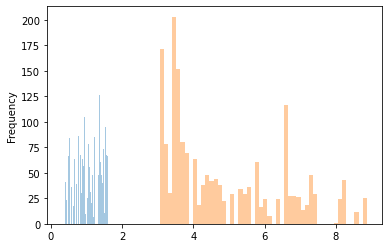

In [70]:
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_low']].plot.hist(bins=50, alpha=0.4, label='obs')
df_hyy_1['OA (microgram m^-3)'][df_hyy_1['OA_high']].plot.hist(bins=50, alpha=0.4, label='obs')



## Get model data:

In [71]:
model_name_noresm = 'NorESM'
model_name_echam  = 'ECHAM-SALSA' 

In [72]:
models =[model_name_noresm,model_name_echam]

### Settings

In [73]:
360-300.99

59.00999999999999

In [74]:
lon_lims = [-67.,-52.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = -59.009
model_lev_i=-1

In [75]:
temperature = 273.15  # K

from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'

### NorEMS

In [76]:
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

#### Input files

In [77]:
fn_noresm = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.nc'
fn_noresm_csv = path_extract_latlon_outdata/ case_name_noresm/f'{case_name_noresm}.h1._{from_time1}-{to_time2}_concat_subs_22.0-30.0_60.0-66.0_lev1_final.csv'

In [78]:

cases_noresm = [case_name_noresm]

#### Station variables

In [79]:
varl_st_noresm = [      'SOA_NA','SOA_A1','OM_NI','OM_AI','OM_AC','SO4_NA','SO4_A1','SO4_A2','SO4_AC','SO4_PR',
      'BC_N','BC_AX','BC_NI','BC_A','BC_AI','BC_AC','SS_A1','SS_A2','SS_A3','DST_A2','DST_A3',
                 ]


varl_cl_noresm = ['TOT_CLD_VISTAU','TOT_ICLD_VISTAU','TGCLDCWP','TGCLDLWP','TGCLDIWP',
           'TOT_CLD_VISTAU_s','TOT_ICLD_VISTAU_s','optical_depth',
           'CLDFREE',
           'FCTL',
           'ACTREL','ACTNL','TGCLDLWP',
           'FSDSC','FSDSCDRF',
           'FCTI',
           'FCTL',
           'FLNS',
           'FLNSC',
           'FLNT',
           'FLNTCDRF',
           'FLNT_DRF',
           'FLUS',
           'FLUTC','FORMRATE',
           'FREQI',
           'FREQL',
           'FSDSCDRF',
           'FSDS_DRF',
           'FSNS',
           'FSNSC',
           'FSNT',
           'FSNTCDRF',
           'FSNT_DRF',
           'FSUS_DRF',
           'FSUTADRF',
           ]

### ECHAM-SALSA

In [80]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'

#### Define some strings for files

In [81]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'-67.0--52.0_-8.0--1.0'

#### Input files:

In [82]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [83]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

In [84]:

cases_echam = [case_name_echam]

#### Station variables

In [85]:
varl_st_echam = ['mmrtrN500',
                 'mmrtrN250',
                 'mmrtrN200',
                 'mmrtrN100',
                 'mmrtrN50',
                 'mmrtrN3',
                 'SO2_gas',
                 'APIN_gas',
                 'TBETAOCI_gas',
                 'BPIN_gas',
                 'LIMON_gas',
                 'SABIN_gas',
                 'MYRC_gas',
                 'CARENE3_gas',
                 'ISOP_gas',
                 'VBS0_gas',
                 'V*BS1_gas',
                 'VBS10_gas',
                 'ORG_mass',
                 'oh_con',
                 'tempair',
                 'ccn02',
                 'ccn10',

          ]


varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
           ]

### READ CVS

In [86]:
df_mod_noresm = pd.read_csv(fn_noresm_csv, index_col=[0,1,2] )


df_mod_noresm = df_mod_noresm[df_mod_noresm['isJA'].notnull()]
df_mod_noresm = df_mod_noresm[df_mod_noresm['isJA'].astype(bool)]

In [87]:
df_mod_echam = pd.read_csv(fn_final_echam_csv, index_col=[0,1,2] )

df_mod_echam = df_mod_echam[df_mod_echam['isJA'].notnull()]
df_mod_echam = df_mod_echam[df_mod_echam['isJA'].astype(bool)]

FileNotFoundError: [Errno 2] No such file or directory: '/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_-67.0--52.0_-8.0--1.0.csv'

In [ ]:
df_hyy_1.index = df_hyy_1.index.rename({'LAT':'lat', 'LON':'lon','date':'time'})

In [ ]:
dic_df=dict()
dic_df[model_name_echam] = df_mod_echam
dic_df[model_name_noresm] = df_mod_noresm
dic_df['Observations'] = df_hyy_1

In [ ]:
df_mod_echam

# Mask data

### NorESM

#### Cloud water path above 50

In [39]:
df_mod = dic_df[model_name_noresm]
mask_cl_waterpath = df_mod['TGCLDCWP']>50

df_mod = df_mod[ mask_cl_waterpath]
dic_df[model_name_noresm] = df_mod

## Masking if less than 10% liquid cloud top fraction and if liquid is less than 80% of the cloud top 

In [40]:
df_mod = dic_df[model_name_noresm]
mask_liq_cloudtop = (df_mod['FCTL']>0.1) & (df_mod['FCTL']/(df_mod['FCTL']+df_mod['FCTI'])>.8)


df_mod.loc[:,'mask_liq_cloudtop'] = mask_liq_cloudtop
dic_df[model_name_noresm] = df_mod[mask_liq_cloudtop]

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='TGCLDCWP', ylabel='CWP'>

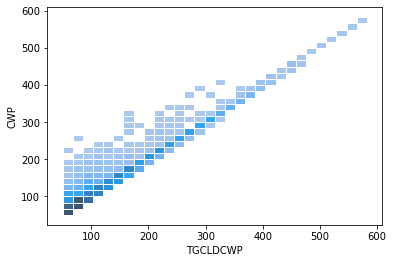

In [41]:
v_x = 'TGCLDCWP'
#ax = axs[1]
df_mod = dic_df[model_name_noresm]

_df = (df_mod[df_mod[v_x].notnull()])#[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]>50]
_df = _df[_df[v_x]<10000]
sns.histplot(
    x=v_x,
    y= 'CWP',
    data=_df,
    #hue=v_hue,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    palette = 'Set1',
    edgecolor='w',
)

## ECHAM

In [42]:
df_mod = dic_df[model_name_noresm]

In [43]:
#mask_cl_waterpath = df_mod['cwp']>50

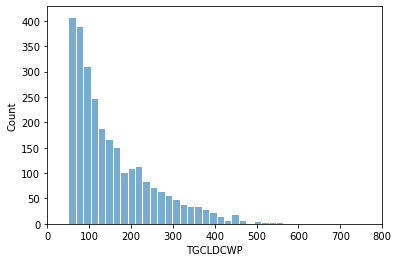

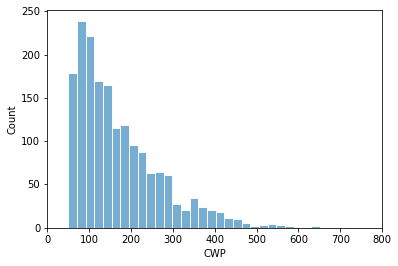

(0.0, 1000.0)

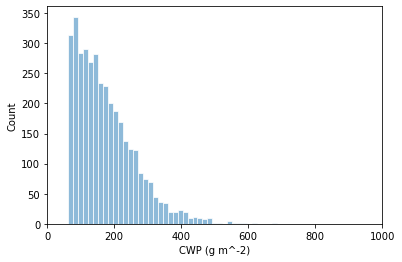

In [44]:
#(1000*df_mod['cwp']).plot.hist()
v_x = 'TGCLDCWP'
#ax = axs[1]
df_mod = dic_df[model_name_noresm]

_df = (df_mod[df_mod[v_x].notnull()])#[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]>50]
_df = _df[_df[v_x]<10000]
sns.histplot(
    x=v_x,
    data=_df,
    #hue=v_hue,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    palette = 'Set1',
    alpha=.6,
    edgecolor='w',
)
plt.xlim([0,800])
plt.show()
v_x = 'CWP'
#ax = axs[1]
df_mod = dic_df[model_name_echam]

_df = (df_mod)#[(df_mod['OA_category'].notna())])
#_df = _df[_df[v_x]>50]
sns.histplot(
    x=v_x,
    data=_df,
    #hue=v_hue,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    palette = 'Set1',
    alpha=.6,
    edgecolor='w',
)
plt.xlim([0,800])
plt.show()

v_x = 'CWP (g m^-2)'
_df = (dic_df['Observations'])#[(df_mod['OA_category'].notna())])
_df = _df[_df[v_x]>50]
sns.histplot(
    x=v_x,
    data=_df,
    #hue=v_hue,
    palette = 'hls',
    alpha=.5,
    #hue_order=hue_order,
    #ax = ax,
    legend=False,
    #palette = _palette,
    edgecolor='w',
)
plt.xlim([0,1000])

In [45]:
dic_df.keys()

dict_keys(['ECHAM-SALSA', 'NorESM', 'Observations'])

### Remove grid vells with no cloud top liquid

More than 10% cloud top liquid fraction in grid cell and 90% of the cloud fraction is covered by liquid. 

## Rename 


In [ ]:
rn_dic_echam = {
    'cwp'      : 'CWP',
    'cod'      : 'COT',
    'ceff_ct'  : 'r_eff',
    
    
}
rn_dic_noresm = {
    'TGCLDCWP_incld'         : 'CWP',
    'TOT_CLD_VISTAU_s_incld': 'COT',
    'ACTREL_incld'     : 'r_eff',
}
rn_dic_obs = {
    'CWP (g m^-2)'        : 'CWP',
    'CER (micrometer)'    : 'r_eff',
    'OA (microgram m^-3)' : 'OA',
    
}



In [46]:
dic_df['Observations'].columns#.keys()

Index(['year', 'month', 'day', 'OA (microgram m^-3)', 'CWP (g m^-2)',
       'CER (micrometer)', 'COT', 'OA_low', 'OA_high', 'OA_category',
       'CWP_cut', 'CWP_qcut', 'CWP_qcutl', 'CWP_cutl'],
      dtype='object')

In [47]:
for key, rn in zip([model_name_noresm, model_name_echam,'Observations'], [rn_dic_noresm, rn_dic_echam, rn_dic_obs]):
    dic_df[key] = dic_df[key].rename(rn, axis=1)

## Group by cloud water path

In [48]:
for key in dic_df.keys():
    df_mod = dic_df[key]
    df_mod['CWP_qcut']=pd.qcut(df_mod['CWP'],6)# bins=bins, labels=labels)§
    df_mod['CWP_qcutl'] = df_mod['CWP_qcut'].apply(lambda x:x.mid)
    dic_df[key] = df_mod

In [49]:
dic_bins = dict()
dic_bins[model_name_noresm] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])
dic_bins[model_name_echam] = pd.IntervalIndex.from_breaks([   50,  80,  110, 140, 170, 200,230, 500])

In [50]:
df_mod = dic_df[model_name_noresm]

v = 'CLDFREE'
df_mod[v].quantile(.99)

0.03423743200000001

In [51]:
df_mod[v].mean()

0.0017118500871747368

In [52]:
df_mod[v].max()

0.27410114

In [53]:
df_mod[v].min()

0.0

In [54]:
for model_name in models:
    df_mod = dic_df[model_name]
    # Optical thickness > 50:
    df_mod = df_mod[df_mod['CWP']>=50]

    bins = dic_bins[model_name]
    df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)

    df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
    df_mod['OA_low'] = df_mod['OA']<df_mod['OA'].quantile(.34)
    df_mod['OA_high']= df_mod['OA']>df_mod['OA'].quantile(.66)
    mid_range = ( df_mod['OA'].quantile(.34)<df_mod['OA']) & (df_mod['OA']<df_mod['OA'].quantile(.66))
    df_mod['OA_mid_range'] = mid_range
    df_mod=df_mod.assign(OA_category= pd.NA)
    df_mod.loc[df_mod['OA_high'], 'OA_category'] = 'OA high'
    df_mod.loc[df_mod['OA_low'], 'OA_category'] = 'OA low'
    
    dic_df[model_name] = df_mod
    
for model_name in [model_name_noresm]:
    df_mod = dic_df[model_name]
    v = 'CLDFREE'
    df_mod[f'{v}_low'] = df_mod[v]<df_mod[v].quantile(.34)
    df_mod[f'{v}_high']= df_mod[v]>df_mod[v].quantile(.66)
    mid_range = ( df_mod[v].quantile(.34)<df_mod[v]) & (df_mod[v]<df_mod[v].quantile(.66))
    df_mod[f'{v}_mid_range'] = mid_range
    df_mod=df_mod.assign(**{f'{v}_category': pd.NA})
    df_mod.loc[df_mod[f'{v}_high'], f'{v}_category'] = f'{v} high'
    df_mod.loc[df_mod[f'{v}_low'], f'{v}_category'] = f'{v} low'
    dic_df[model_name] = df_mod

/tmp/ipykernel_171304/1695915962.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cut']=pd.cut(df_mod['CWP'], bins=bins)#, labels=labels)
/tmp/ipykernel_171304/1695915962.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['CWP_cutl'] = df_mod['CWP_cut'].apply(lambda x:x.mid)
/tmp/ipykernel_171304/1695915962.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

## Category of OA concentration

## Distribution plots:

In [56]:
palette = 'Set2'

In [57]:
import numpy as np

In [58]:
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [59]:
#cmap = cm.get_cmap(name=palette, )
cmap_list = ['#441FE0','#BBE01F'][::-1]#cmap(a) for a in np.linspace(0,1,8)]

In [60]:
palette_OA = cmap_list[0:2]

3673


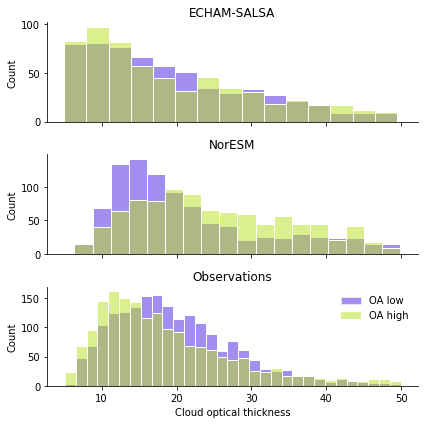

In [61]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])
v_x = 'COT'
x_cut = 100
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud optical thickness')
#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()

3673


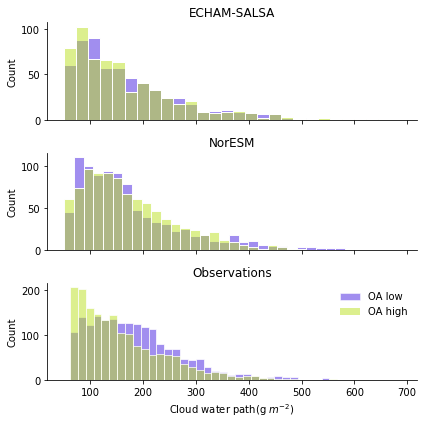

In [62]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6])

v_x = 'CWP'
x_cut = 700
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud water path(g $m^{-2}$)')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(3,1, sharex=True, figsize =[6,6], dpi=100)

v_x = 'r_eff'
x_cut = 700
v_hue = 'OA_category'
hue_order=['OA low', 'OA high'][::-1]

_palette = palette_OA#cmap_list[0:2]


for key, ax in zip(dic_df.keys(), axs):
    _df = dic_df[key].copy()
    _df = _df[_df[v_x]<x_cut]
    _df = _df[_df[v_x]>0]

    sns.histplot(
        x=v_x,
        data=_df,
        hue=v_hue,
        hue_order=hue_order,
        palette=_palette,
        legend=False,
        edgecolor='w',
        ax = ax
    )
#plt.ylim([0,250])
    ax.set_title(key)#'Observations')



custom_lines = [Line2D([0], [0], color=cmap_list[0], lw=4),
                Line2D([0], [0], color=cmap_list[1], lw=4),
               # Line2D([0], [0], color=cmap(1.), lw=4)

               ]

leg_els = [

    Patch(edgecolor='w',alpha = .5, facecolor=_palette[1], label='OA low'),
    Patch(edgecolor=None, alpha = .5,facecolor=_palette[0], label='OA high'),

]

ax.legend(handles = leg_els, frameon=False)
ax.set_xlabel('Cloud droplet effective radius at cloud top [$\mu m$]')

#plt.ylim([0,250])
print(len(_df))
sns.despine(fig)

fn = make_fn('echam_noresm', v_x,'obs',comment='distribution')

#fig.savefig(fn, dpi=150)
fig.tight_layout()

### Fractional occurance of cloud top liquid

## Cloud optical thickness

### Incloud

In [117]:
hue_order = ['OA low','OA high']#[::-1]
palette_OA_2 = palette_OA[::-1]

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


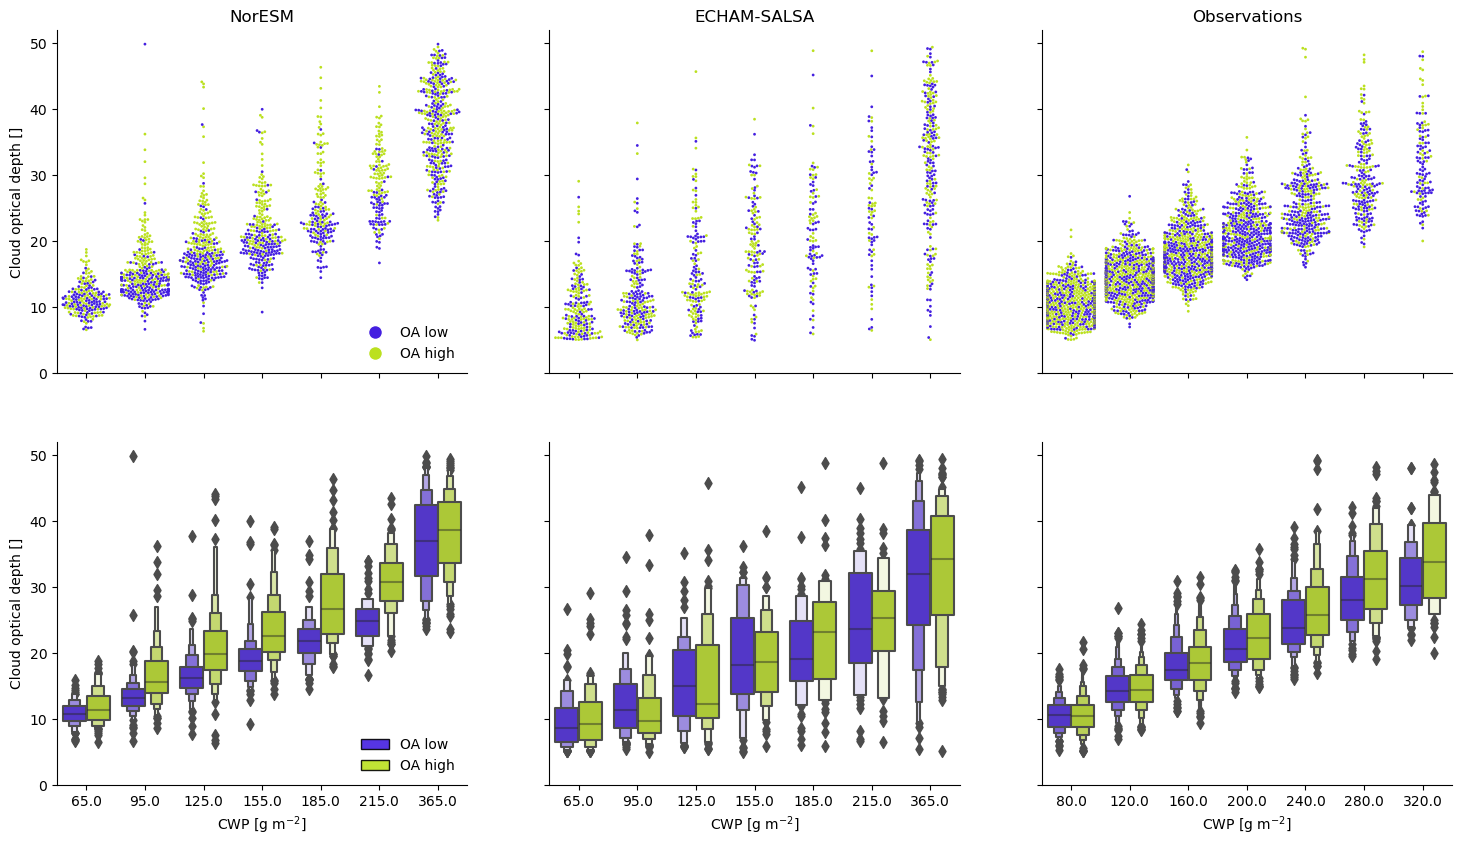

In [118]:
x_var = 'CWP_cutl'
y_var = 'COT'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,52]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(dic_df.keys(), axs[0,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(dic_df.keys(), axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('Cloud optical depth []')
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

fn = make_fn('noresm_echam', x_var,y_var, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


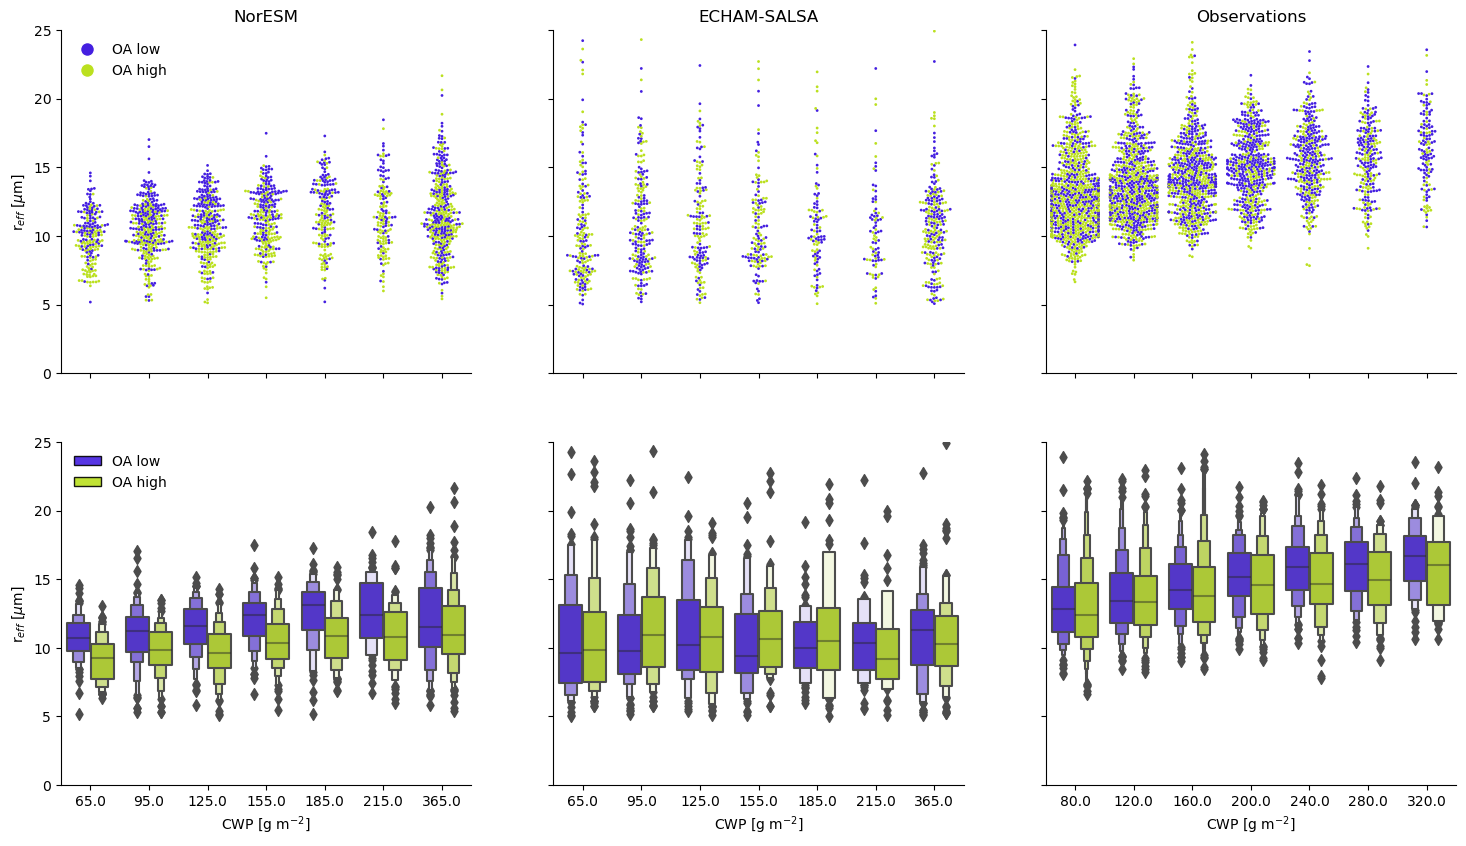

In [119]:
x_var = 'CWP_cutl'
y_var = 'r_eff'
hue_var = 'OA_category'
hue_labs = ['OA low', 'OA high']
ylim = [0,25]
figsize = [18,10]
_palette = palette_OA_2

#fig, axs = plt.subplots(2,2,figsize=figsize, sharey=True, sharex=True)
fig, axs = plt.subplots(2,3,figsize=figsize, sharey=True, sharex='col', dpi=100)

markersize= 2


for key,ax in zip(dic_df.keys(), axs[0,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]

    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]
    
    sns.swarmplot(
        x=x_var,
        y=y_var,
        data=_df_lim,
        hue_order=hue_order,
        hue=hue_var,
        palette=_palette,
        size = markersize,
        ax = ax,
    )
    ax.set_title(key)

for key,ax in zip(dic_df.keys(), axs[1,:]):
    _df = dic_df[key].copy()
    
    _df_lim =_df[(_df[y_var]<=ylim[1])& (_df[y_var]>=ylim[0])]
    _df_lim = _df_lim[_df_lim[x_var].notna()]
    _df_lim = _df_lim[_df_lim[y_var].notna()]
    _df_lim = _df_lim[_df_lim[hue_var].notna()]

    sns.boxenplot(
        x=x_var,
        y=y_var,
        data= _df_lim,
        hue_order=hue_order,#['OA low','OA high'],
        hue=hue_var,
        #kind='boxen',
        ax = ax,
        palette=_palette,
           )


    

    ## ADJUSTMENTS

for ax in axs.flatten():
    ax.legend([],[], frameon=False)
    ax.set_ylabel(None)


leg_els = [
    Patch(edgecolor='k', alpha = .9,facecolor=_palette[0], label=hue_labs[0]),
    Patch(edgecolor='k',alpha = .9, facecolor=_palette[1], label=hue_labs[1]),
          ]
axs[1,0].legend(handles = leg_els, frameon=False)

leg_els = [
     Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[0], markersize=10,
            label=hue_labs[0]
           ),
         Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=_palette[1], markersize=10,
            label=hue_labs[1]
           ),
          ]
axs[0,0].legend(handles = leg_els, frameon=False)

for ax in axs[:,0]:
    ax.set_ylabel('r$_{eff}$ [$\mu$m]')
    
for ax in axs[1,:]:
    ax.set_xlabel('CWP [g m$^{-2}$]')
for ax in axs[0,:]:
    ax.set_xlabel(None)

for ax in axs.flatten():

    ax.set_ylim(ylim)



sns.despine(fig)

fn = make_fn('noresm_echam', x_var,y_var, comment='binned_by_x')
fig.savefig(fn, dpi=150)
plt.show()

### Grid box avg